In [1]:
import math
import os
import sys
sys.path.append("..")
import random
import numpy as np
import torch
import torch.optim as optim
from pathlib import Path
import matplotlib.pyplot as plt
from IPython.display import clear_output, display
import torchvision.transforms as T
from source.cliploss import Loss
from source.beziercurve import CurveSet
from source.diffrasterizer import rasterize_spheres
from types import SimpleNamespace

from source.imagesampler import ImageSampler
%load_ext autoreload
%autoreload 2

In [2]:
import math
import os
import sys
import torch
import numpy as np
from PIL import Image
from matplotlib import pyplot as plt
from mpl_toolkits.mplot3d import Axes3D  # noqa: F401 (for 3d projection)
from mpl_toolkits.mplot3d.art3d import Poly3DCollection
import torchvision.transforms as T
sys.path.append("..")
from source.utils import load_scene


In [3]:
# --- Settings ---
device = 'cuda' if torch.cuda.is_available() else 'cpu'
width, height = 224, 224
batch_size = 1
epochs = 400
inner_steps = 30
thickness = 0.5
learning_rate = 0.001
save_dir = Path('training_frames')
save_dir.mkdir(exist_ok=True)



In [4]:
# --- Prepare data sampler for a single scene ---
data_name = 'Elko'
transforms_json = '../data/{}/transforms_train.json'.format(data_name)
image_dir = '../data/{}/rgb/'.format(data_name)
sampler = ImageSampler(
    transforms_json=transforms_json,
    image_dir=image_dir,
    width=width,
    height=height,
    device=device,
)

In [5]:

# --- Prepare loss and rasterizer ---
args = SimpleNamespace(
    device=device,
    percep_loss='none',
    train_with_clip=True,
    clip_weight=1.0,
    start_clip=0,
    clip_conv_loss=1,
    clip_fc_loss_weight=0.1,
    clip_text_guide=0.0,
    num_aug_clip=4,
    augemntations=['affine'],
    include_target_in_aug=False,
    augment_both=False,
    clip_model_name='ViT-B/32',
    clip_conv_loss_type='L2',
    clip_conv_layer_weights=[0, 0, 1.0, 1.0, 0.0]
)
criterion = Loss(args).to(device)
rasterizer = torch.compile(rasterize_spheres)

In [6]:
import torch
import numpy as np

def object_short_lines(
    vertices: np.ndarray,
    normals: np.ndarray,
    n_curves: int,
    length: float,
    device: str = "cuda"
):
    """
    Initialize short 4-point Bézier curves centered on random mesh vertices,
    oriented tangentially to the surface.

    Args:
      vertices   : (V,3) numpy array of mesh vertex positions in world space.
      normals    : (V,3) numpy array of per-vertex normals.
      n_curves   : how many Béziers to sample.
      length     : total length of each curve (in world units).
      device     : torch device.

    Returns:
      List of n_curves tensors, each of shape (4,3), ready to feed into BezierCurve.
    """
    V = vertices.shape[0]
    verts_t = torch.from_numpy(vertices).to(device).float()    # (V,3)
    norms_t = torch.from_numpy(normals).to(device).float()     # (V,3)

    # pick a random subset of vertex indices
    idxs = torch.arange(V, device=device)

    curves = []
    offsets = torch.linspace(-0.5, 0.5, steps=4, device=device) * length  # (4,)

    for idx in idxs:
        base = verts_t[idx]      # (3,)
        nrm  = norms_t[idx]      # (3,)
        # sample a random tangent direction: pick random v, subtract its normal component
        v = torch.randn(3, device=device)
        tang = v - (v.dot(nrm)) * nrm
        tang = tang / (tang.norm() + 1e-5)

        # build 4 control points along that tangent line
        ctrl_pts = base.unsqueeze(0) + offsets.unsqueeze(1) * tang.unsqueeze(0)
        curves.append(ctrl_pts)  # (4,3)

    return curves


In [7]:
import trimesh

# 1) load mesh (OBJ exported from Blender)
mesh = trimesh.load('../data/elko_debug.obj', process=False)
# get vertices & normals
verts   = np.array(mesh.vertices)         # (V,3)
nrm     = np.array(mesh.vertex_normals)   # (V,3)
verts[:, 2] = -verts[:, 2]
verts[:, [1, 2]] = verts[:, [2, 1]]

# 2) sample 100 tiny curves on the surface
init_pts = object_short_lines(
    vertices=verts,
    normals =nrm,
    n_curves=100,
    length  =0.02,
    device  ='cuda'
)

# 3) create your CurveSet and rasterize as before
curve_set = CurveSet(
    init_pts,
    thickness = 0.05,
    overlap   = 0.8,
    arc_samples=200,
    device    ='cuda'
).to('cuda')

means, radii = curve_set()


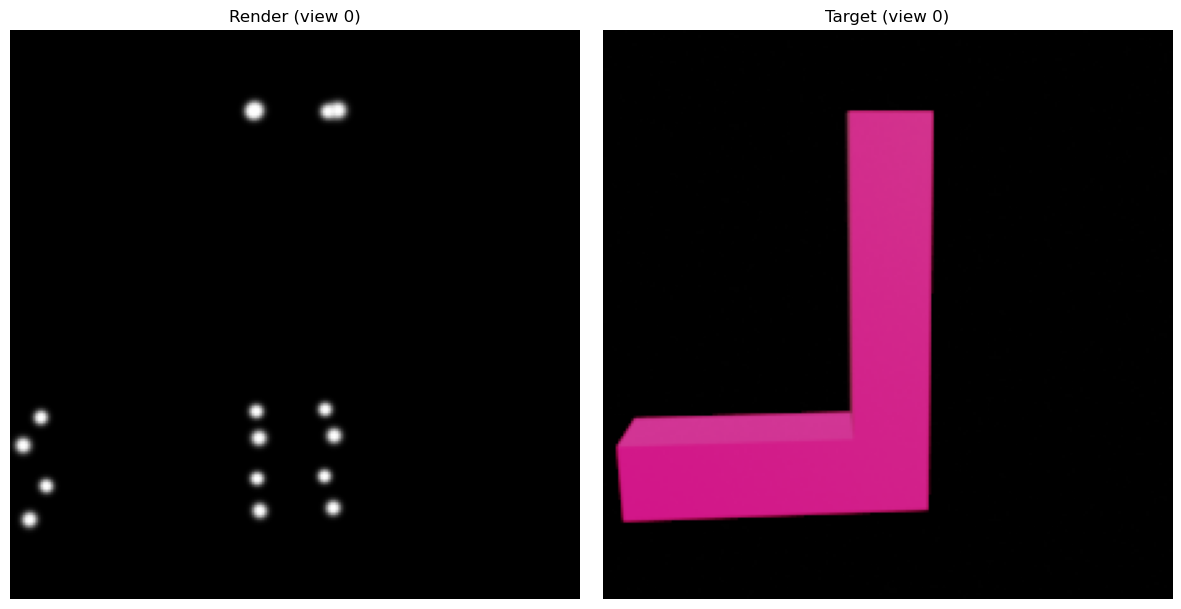

In [10]:
import matplotlib.pyplot as plt
from IPython.display import display

# --- 1) Grab the very first view from your sampler ---
# (Adjust these names if yours differ)
first_rgb, first_K, first_w2c = sampler.sample(90)

# --- 2) Do one forward render of your current CurveSet ---
means, thicknesses = curve_set()  # get the (N,3) & (N,) batch
img_t = rasterizer(
    means, thicknesses,
    first_w2c, first_K,
    width, height
)  # returns (H,W,1)


# Convert to (H,W,3) for RGB display
img_np = img_t.permute(2,0,1).cpu().detach().numpy()[0]    # (H,W)
img_rgb_render = np.stack([img_np]*3, axis=-1)    # (H,W,3)

# Extract the target as (H,W,3)
target_np = first_rgb[0].permute(1,2,0).cpu().numpy()

# --- 3) Plot side-by-side ---
plt.ioff()
fig, (ax_r, ax_t) = plt.subplots(1, 2, figsize=(12,6))

ax_r.imshow(img_rgb_render, vmin=0, vmax=1)
ax_r.set_title("Render (view 0)")
ax_r.axis('off')

ax_t.imshow(target_np, vmin=0, vmax=1)
ax_t.set_title("Target (view 0)")
ax_t.axis('off')

plt.tight_layout()
plt.show()


In [23]:
# --- Initialize curves as short lines at random locations on a sphere ---
def random_short_lines(center: torch.Tensor,
                       n_curves: int,
                       radius: float,
                       length: float,
                       device: str):
    """
    center: (3,) origin of the sphere
    n_curves: how many line‐curves to make
    radius:  how far from center to place each line
    length:  total length of each line segment
    """
    lines = []
    for _ in range(n_curves):
        # 1) Pick a random point ON the sphere
        dir_loc = torch.randn(3, device=device)
        dir_loc = dir_loc / dir_loc.norm()
        loc = center + radius * dir_loc       # (3,)

        # 2) Pick a random line direction orthogonal to dir_loc
        dir_line = torch.randn(3, device=device)
        dir_line = dir_line - (dir_line @ dir_loc) * dir_loc
        dir_line = dir_line / dir_line.norm()

        # 3) Build 4 control points along that line of total length `length`
        offsets = torch.tensor([-0.5, -0.1667, 0.1667, 0.5],
                               device=device) * length  # (4,)
        ctrl_pts = loc[None] + offsets[:, None] * dir_line[None]  # (4,3)

        lines.append(ctrl_pts)
    return lines

# Convert numpy center to torch
center_t = torch.tensor(sampler.scene_center,
                        device=device, dtype=torch.float32)

# Parameters
n_curves = 20
radius   = 0.7    # how far out to place each line from center
length   = 0.01    # how long each line is
thickness = 0.05

# Generate
init_pts = random_short_lines(center_t, n_curves, radius, length, device)

# Create & optimize
curve_set = CurveSet(init_pts,
                     thickness=thickness,
                     overlap=0.6,
                     arc_samples=300,
                     device=device).to(device)
optimizer = optim.Adam(curve_set.parameters(), lr=learning_rate)

In [50]:
import torch
import numpy as np

def object_short_lines(
    vertices: np.ndarray,
    normals: np.ndarray,
    n_curves: int,
    length: float,
    device: str = "cuda"
):
    """
    Initialize short 4-point Bézier curves centered on random mesh vertices,
    oriented tangentially to the surface.

    Args:
      vertices   : (V,3) numpy array of mesh vertex positions in world space.
      normals    : (V,3) numpy array of per-vertex normals.
      n_curves   : how many Béziers to sample.
      length     : total length of each curve (in world units).
      device     : torch device.

    Returns:
      List of n_curves tensors, each of shape (4,3), ready to feed into BezierCurve.
    """
    V = vertices.shape[0]
    verts_t = torch.from_numpy(vertices).to(device).float()    # (V,3)
    norms_t = torch.from_numpy(normals).to(device).float()     # (V,3)

    # pick a random subset of vertex indices
    idxs = torch.arange(V, device=device)

    curves = []
    offsets = torch.linspace(-0.5, 0.5, steps=4, device=device) * length  # (4,)

    for idx in idxs:
        base = verts_t[idx]      # (3,)
        nrm  = norms_t[idx]      # (3,)
        # sample a random tangent direction: pick random v, subtract its normal component
        v = torch.randn(3, device=device)
        tang = v - (v.dot(nrm)) * nrm
        tang = tang / (tang.norm() + 1e-5)

        # build 4 control points along that tangent line
        ctrl_pts = base.unsqueeze(0) + offsets.unsqueeze(1) * tang.unsqueeze(0)
        curves.append(ctrl_pts)  # (4,3)

    return curves


In [51]:
import trimesh

# Parameters
n_curves = 20
radius   = 0.7    # how far out to place each line from center
length   = 0.01    # how long each line is
thickness = 0.05


# 1) load mesh (OBJ exported from Blender)
mesh = trimesh.load('../data/elko_debug.obj', process=False)
print(mesh)
# get vertices & normals
verts   = np.array(mesh.vertices)         # (V,3)
nrm     = np.array(mesh.vertex_normals)   # (V,3)
verts[:, 2] = -verts[:, 2]
verts[:, [1, 2]] = verts[:, [2, 1]]

# 2) sample 100 tiny curves on the surface
init_pts = object_short_lines(
    vertices=verts,
    normals =nrm,
    n_curves=100,
    length  =0.02,
    device  ='cuda'
)

# 3) create your CurveSet and rasterize as before
# Create & optimize
curve_set = CurveSet(init_pts,
                     thickness=thickness,
                     overlap=0.6,
                     arc_samples=300,
                     device=device).to(device)
optimizer = optim.Adam(curve_set.parameters(), lr=learning_rate)

means, radii = curve_set()


<trimesh.Trimesh(vertices.shape=(16, 3), faces.shape=(28, 3))>


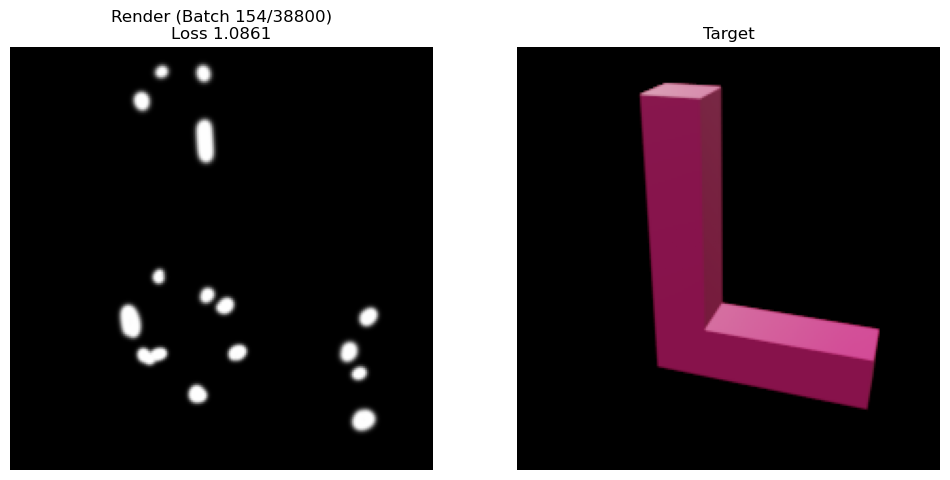

KeyboardInterrupt: 

In [53]:
# --- Setup display as 1×2 subplots ---
plt.ioff()
fig, (ax_render, ax_target) = plt.subplots(1, 2, figsize=(12, 6))

# placeholder for the render
im_render = ax_render.imshow(
    torch.zeros((height, width, 3), dtype=torch.float32).numpy(),
    vmin=0, vmax=1
)
ax_render.set_title("Render")
ax_render.axis('off')

# placeholder for the target
# assume the very first sample shows its target
first_target = sampler.images[0][0].permute(1,2,0).cpu().numpy()
im_target = ax_target.imshow(first_target, vmin=0, vmax=1)
ax_target.set_title("Target")
ax_target.axis('off')

# --- Training loop (multi‐step per batch) ---
N_views          = len(sampler.images)
updates_per_epoch= math.ceil(N_views / batch_size)
total_batches    = updates_per_epoch * epochs

for batch_idx in range(total_batches):
    # 1) sample a fresh batch of views
    batch_data = []
    for _ in range(batch_size):
        v_idx = random.randrange(N_views-1)
        batch_data.append((
            sampler.images[v_idx],      # target_rgb (1,3,H,W)
            sampler.K,                  # K
            sampler.w2c_all[v_idx+1]      # world‐to‐camera
        ))

    # 2) take `inner_steps` gradient updates on this same batch
    for inner in range(inner_steps):
        optimizer.zero_grad()
        losses = []
        for target_rgb, K, w2c in batch_data:
            means, thicknesses = curve_set()
            img = rasterizer(means, thicknesses, w2c, K, width, height)
            img = img.permute(2,0,1).unsqueeze(0).repeat(1,3,1,1)
            it = batch_idx * inner_steps + inner
            losses.append(criterion(img, target_rgb, it))
        loss = torch.stack(losses).mean()
        loss.backward()
        optimizer.step()

    # after inner steps, display both render and its corresponding target
    # take the *last* rendered img and the *first* target in batch_data as example
    render_np = img[0].permute(1,2,0).detach().cpu().numpy()
    target_np = batch_data[0][0][0].permute(1,2,0).cpu().numpy()

    im_render.set_data(render_np)
    im_target.set_data(target_np)

    ax_render.set_title(
        f"Render (Batch {batch_idx}/{total_batches})\nLoss {loss.item():.4f}"
    )
    ax_target.set_title("Target")

    fig.canvas.draw()
    fig.savefig(save_dir / f'batch_{batch_idx:04d}.png',
                bbox_inches='tight', pad_inches=0)
    clear_output(wait=True)
    display(fig)

plt.show()

In [24]:
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D  # noqa: F401

def plot_spheres_matplotlib(
    means: np.ndarray,
    radii: np.ndarray,
    resolution: int = 20,
    alpha: float = 0.6,
    colormap: str = "viridis"
):
    """
    Plot 3D spheres centered at `means` with given `radii`, using Matplotlib.

    Args:
        means      (N,3) numpy array of sphere centers
        radii      (N,)  numpy array of sphere radii
        resolution number of subdivisions in θ,ϕ (higher → smoother)
        alpha      transparency of each sphere
        colormap   name of a matplotlib colormap for coloring spheres
    """
    # parameterize a unit sphere
    u = np.linspace(0, 2 * np.pi, resolution)
    v = np.linspace(0, np.pi, resolution)
    uu, vv = np.meshgrid(u, v)

    fig = plt.figure(figsize=(5, 5),dpi = 600)
    ax = fig.add_subplot(111, projection="3d")

    cmap = plt.get_cmap(colormap)
    N = len(means)

    for i, ((x0, y0, z0), r) in enumerate(zip(means, radii)):
        # compute sphere surface
        x = x0 + r * np.cos(uu) * np.sin(vv)
        y = y0 + r * np.sin(uu) * np.sin(vv)
        z = z0 + r * np.cos(vv)

        # pick a color from the colormap
        color = cmap(i / max(1, N - 1))  # RGBA tuple
        # now build a (res,res,4) array of that color
        fc = np.broadcast_to(np.array(color)[None, None, :], x.shape + (4,))

        ax.plot_surface(
            x, y, z,
            rstride=1, cstride=1,
            facecolors=fc,
            edgecolor='k',    # draw black edges
            linewidth=0.2,    # thin lines
            shade=True,
            alpha=alpha
        )

    # equal aspect ratio
    xyz = np.vstack([means + radii[:, None], means - radii[:, None]])
    x_limits = (xyz[:, 0].min(), xyz[:, 0].max())
    y_limits = (xyz[:, 1].min(), xyz[:, 1].max())
    z_limits = (xyz[:, 2].min(), xyz[:, 2].max())
    max_range = np.array([
        x_limits[1] - x_limits[0],
        y_limits[1] - y_limits[0],
        z_limits[1] - z_limits[0],
    ]).max() / 2.0

    mid_x = np.mean(x_limits)
    mid_y = np.mean(y_limits)
    mid_z = np.mean(z_limits)

    #ax.set_xlim(mid_x - max_range, mid_x + max_range)
    #ax.set_ylim(mid_y - max_range, mid_y + max_range)
    #ax.set_zlim(mid_z - max_range, mid_z + max_range)

    ax.set_xlabel("X")
    ax.set_ylabel("Y")
    ax.set_zlabel("Z")
    ax.grid(False)

    plt.tight_layout()
    plt.savefig("3D_spheres_plot.png", dpi=600)
    plt.show()

In [ ]:
means_np = means.detach().cpu().numpy()
radii_np = thicknesses.detach().cpu().numpy()
plot_spheres_matplotlib(means_np, radii_np*2, resolution=5, alpha=1.0)

In [ ]:
from PIL import Image as PILImage

# Gather and sort saved frames
frame_paths = sorted(save_dir.glob("batch_*.png"))
frames = [PILImage.open(p) for p in frame_paths]

# Save GIF
gif_path = "training_evolution.gif"
frames[0].save(gif_path, save_all=True, append_images=frames[1:], duration=50, loop=0)
print(f"GIF saved to {gif_path}")